# Binaryzacja


### Cel:
- zapoznanie z segmentacją obiektów poprzez binaryzację,
- zapoznanie z binaryzacją na podstawie histogramu (globalną),
- zapoznanie z metodami automatycznego wyznaczania progu Ots'u, Kitller'a i Kapur'a,
- zapoznanie z binaryzacją lokalną (na podstawie średniej i metodą Sauvola),
- zapoznanie z binaryzacją dwuprogową,
- zadanie domowe: zapoznanie z adaptacyjną binaryzacją lokalną.

### Binaryzacja - wprowadzenie

Jednym z najważniejszych etapów podczas analizy obrazów jest segmentacja -- podział obrazu na rejony według pewnego kryterium  -- jasności, koloru, tekstury.
Najprostszą (i też najczęściej wykorzystywaną) metodą segmentacji jest **binaryzacja**. 
Do jej głównych zalet zalicza się: intuicyjność, prostotę, łatwość implementacji i szybkość wykonywania. 
Jest ona etapem wielu algorytmów analizy obrazów. 
Pozwala na znaczną redukcję informacji w obrazie (np. dla wejściowego obrazu w skali szarości z zakresu 0-255 do 0-1).
 
Binaryzacja najczęściej realizowana jest poprzez progowanie. 
Na przykład: dla obrazu w odcieniach szarości ustala się próg na poziomie $k$. 
Wszystkie piksele o wartości (jasności) większej od $k$ zostają uznane za obiekty, a pozostałe za tło. 
Oczywiście podejście takie daje się zastosować wtedy, gdy obiekty mają istotnie różną jasność od otaczającego je tła.


### Binaryzacja na podstawie histogramu

W rozdziale zostanie zademonstrowane wyznaczanie progu na podstawie "ręcznej" analizy histogramu oraz wpływ szumu i niejednorodnego oświetlenia sceny na proces binaryzacji.

1. Potrzebne w ćwiczeniu moduły są już wpisane - zwróć uwagę pod jakimi nazwami będą one widziane (plt, cv2, np).

2. Wczytaj obraz _coins.png_ w trybie odcieni szarości. Wyświetl go. 
Wyznacz jego histogram (funkcja `np.histogram` lub 'cv2.calcHist') i wyświetl go.
Przy wyświetlaniu histogramu warto zwiększyć liczbę wyświetlanych wartości na osi x oraz powiększyć sam wykres (funkcje *plt.xticks(np.arange(0, 256, 20.0))* oraz *plt.rcParams["figure.figsize"] = (10,5)*.
Uwaga. Proszę powyższą funkcjonalność zaimplementować jako funkcję, gdyż przyda się w dalszej części ćwiczenia.
      


In [2]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/04_Thresholding/'

fileNames = ["coins.png", "rice.png", "catalogue.png", "bart.png", "figura1.png", "figura2.png", "figura3.png", "figura4.png", "T.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

3. Wizualna analiza histogramu pozwala zauważyć dwa maksima - jedno odpowiadające poziomowi jasności tła (które w tym przypadku jest względnie jednolite - ciemnoszare) i drugie odpowiadające monetom.

Na podstawie histogramu wyznacz próg i wykonaj binaryzację:
- wykorzystaj fakt, że dla macierzy *numpy* można wykonać operację porównania wszystkich jej wartości z liczbą  - wynikiem jest macierz zawierająca wartości *True* i *False*, którą można przekonwertować metodą macierz.astype(np.int) na macierz z wartościami 1 i 0 (aczkolwiek nie jest to tu konieczne).
- wynik binaryzacji wyświetl,
- spróbuj dobrać jak najlepszy próg binaryzacji. Jako "kryterium jakości" przyjmij kształty monet - dla poprawnie dobranego progu powinny to być wypełnione koła.

Uwaga. Proszę powyższą funkcjonalność zaimplementować jako funkcję, gdyż przyda się w dalszej części ćwiczenia.

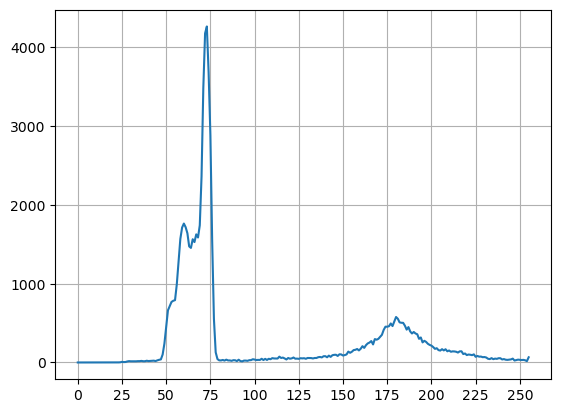

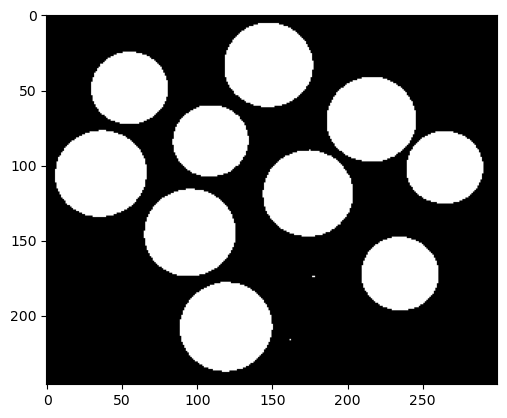

In [3]:
def binar(name, threshold=100):
    image = cv2.imread(name,cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([image],[0],None,[256],[0,256])

    binary_image = image>threshold
    binary_image=binary_image.astype("uint8")

    plt.plot(hist)
    plt.grid()
    plt.locator_params(axis='x', nbins=13)
    plt.show()
    plt.imshow(binary_image, cmap='gray')
    plt.show()
binar("coins.png",80)

4. Na "stopień trudności" przeprowadzenia binaryzacji największy wpływ mają dwa czynniki:
- szum,
- niejednorodne oświetlenie.
	  
Użyj obrazy:
 - _figura1.png_ (bez zaszumienia),
 - _figura2.png_ (dodany szum Gaussowski o średniej 0 i odchyleniu standardowym 10),
 - _figura3.png_ (dodany szum Gaussowski o średniej 0 i odchyleniu standardowym 50),
 - _figura4.png_ (dodany gradient oświetlenia -- symulacja oświetlenia niejednorodnego) i wyświetl ich histogramy (wykorzystaj funkcję z poprzedniego punktu).


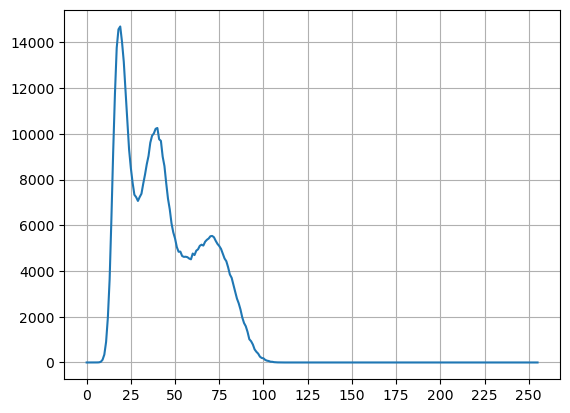

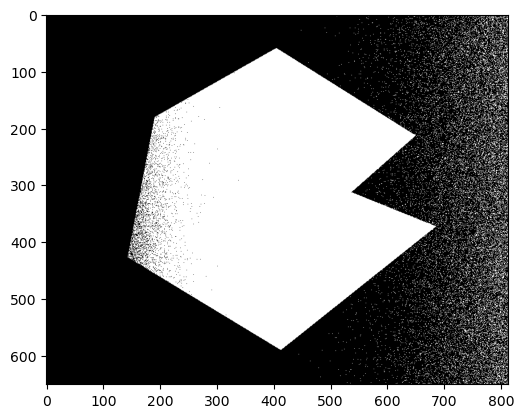

In [4]:
# binar("figura1.png",76)
# binar("figura2.png",125)
# binar("figura3.png",120)
binar("figura4.png",48)

Spróbuj wyznaczyć progi binaryzacji na podstawie wyświetlonych histogramów.
Jak dodanie szumu wypłynęło na histogram i łatwość wyznaczania progu binaryzacji?
Czy jest to możliwe we wszystkich przypadkach?

### Automatyczne wyznaczanie progu binaryzacji

W automatycznym systemie analizy obrazów (działanie bez nadzoru operatora) konieczne jest zastosowanie metody binaryzacji, która w sposób automatyczny wyznacza próg binaryzacji.
Oczywiście można sobie wyobrazić użycie stałego progu (np. 10), ale wtedy należy zadbać o niezmienność warunków oświetleniowych, co w niektórych zastosowaniach może być problematyczne.

#### Iteracyjne wyznaczenie progu

Jednym z najprostszych podejść jest iteracyjna procedura wyliczania progu.
Jako pierwsze przybliżenie progu ($k$) przyjmuje się średnia jasność na obrazie.
Następnie, na podstawie $k$,  dzieli się obraz na dwa podobrazy $I_0$ i  $I_1$ (dwie klasy $C_0$ i $C_1$).
Dla każdego z nich oblicza się średnią jasność: $m_0$ i $m_1$.
Jako nowy próg przyjmuje się:
\begin{equation}
\label{eq:thresholding:mean_auto} \tag{1}
k_{new} = \frac{m_0 + m_1}{2}
\end{equation}
Procedurę kontynuuje się do momentu, aż różnica pomiędzy dwoma kolejnymi progami będzie mniejsza niż zadana wartość.


**Zadanie: zaimplementować opisany powyżej algorytm.**


Jak można zauważyć, do poprawnego działania metody potrzebne będzie obliczanie średniej jasności, również dla pewnych podobrazów.
Wykorzystamy do tego znormalizowanych histogram:
\begin{equation}
\label{eq:p_i} \tag{2}
p_i = n_i/N,   \sum_{i=0}^L p_i = 1
\end{equation}
gdzie: $n_i$ liczba pikseli o jasności $i$ ($i = 0,1, ... L-1$) - histogram, $L$ - liczba poziomów jasności, $N$ - liczba pikseli na obrazie ($N = n_0 + n_1 + ... + n_{L-1}$).

Jeśli podzielimy obraz na dwie klasy $C_0$ i $C_1$ (tło i obiekty albo obiekty i tło) z progiem podziału oznaczonym jako $k$, to do klasy $C_0$ należeć będą piksele o poziomach $[0,k]$, a do klasy $C1$ piksele o poziomach $[k+1,L-1]$.

Wtedy prawdopodobieństwo, że piksel należy do klasy $C_0$ wynosi:
\begin{equation}
\label{eq:P_0} \tag{3}
P_0(k) = \sum_{i=0}^{k} p_i
\end{equation}

Podobnie prawdopodobieństwo, że należy do klasy $C_1$ wynosi:

\begin{equation}
\label{eq:P_1} \tag{4}
P_1(k) = \sum_{i=k+1}^{L-1} p_i = 1 - P_0(k)
\end{equation}

Średnią jasność pikseli należących do klasy $C_0$ można wyznaczyć na podstawie:

\begin{equation}
\label{eq:m_0} \tag{5}
m_0(k) = \sum_{i=0}^{k} iP(i|C_0)
\end{equation}

gdzie: $|$ oznacza prawdopodobieństwo warunkowe, a wyraz $P(i|C_0)$ - prawdopodobieństwo dla wartości $i$ pod warunkiem, że $i$ należy do klasy $C_0$.
Równanie to jest szczególnym przypadkiem wykorzystania momentów statystycznych do wyliczania pewnych parametrów statystycznych - w tym przypadku średniej.

Wykorzystując regułę Bayesa:

\begin{equation}
\label{eq:P_A_B} \tag{6}
P(A|B) = P(B|A)P(A)/P(B)
\end{equation}
możemy zapisać:

\begin{equation}
\label{eq:m_0k} \tag{7}
m_0(k) = \sum_{i=0}^{k} i P(C_0|i)P(i)/P(C_0)
\end{equation}
Wyraz $P(C_0|i) = 1$, gdyż z założenia rozpatrujemy tylko piksele należące do klasy $C_0$.
Wyraz $P(i)$ stanowi $i$-ty element znormalizowanego histogramu tj. $P(i) = p_i$, a $P(C_0)$ to prawdopodobieństwo przynależności do klasy $C_0$ określone wcześniej $P(C_0) = P_0(k)$.
Ostatecznie możemy więc zapisać:

\begin{equation}
\label{eq:thresholding:meanHistC0} \tag{8}
m_0(k) = \frac{1}{P_0(k)} \sum_{i=0}^{k} i p_i
\end{equation}

Na podstawie analogicznych rozważań można wyprowadzić wzór na średnią jasności pikseli należących do klasy $C_1$:
\begin{equation}
\label{eq:thresholding:meanHistC1}  \tag{9}
m_1(k) = \frac{1}{P_1(k)} \sum_{i=k+1}^{L-1} i p_i
\end{equation}

Średnia jasność całego obrazu dana jest zależnością:
\begin{equation}
\label{eq:thresholding:meanHistGlobal} \tag{10}
m_G = \sum_{i=0}^{L-1} ip_i
\end{equation}


1. Wczytaj obraz _coins.png_. Wyświetl go.

2. Wylicz histogram i histogram skumulowany (funkcja `np.cumsum`).
   Na podstawie zależności (\ref{eq:thresholding:meanHistGlobal}) wylicz średnią - pierwszy próg podziału $k$.
   Uwagi:
   - przed dalszymi obliczeniami dobrze jest usunąć zbędny wymiar tablicy z histogramem - polecenie `np.squeeze`
    - $p_i$ to nasz znormalizowany histogram, a wartości od $0$ do $255$ można wygenerować poleceniem `np.arange(256)`,
    - zmiast pętli `for` można wykorzystać iloczyn sklarny dwóch wektorów tj. `np.dot`.

3.  W nieskończonej petli `while` wykonaj następujące kroki:
- oblicz średnią $m_0$ -- zależność (\ref{eq:thresholding:meanHistC0}):
    - dla $P_0$ wystarczy wykorzystać odpowiednią wartość znormalizowanego histogramu skumulowanego, dla pozostałej części wyrażenia podobne rozwiązanie jak dla pierwszej średniej,
- oblicz średnią $m_1$ -- zależność (\ref{eq:thresholding:meanHistC1}),
- oblicz nowy próg $k_{new}$ -- zależność (\ref{eq:thresholding:mean_auto}),
- oblicz moduł z różnicy pomiędzy $k_{new}$, a $k$ i sprawdź czy jest mniejszy od progu (np. $1$),
- jeśli tak to zakończ obliczenia (`break`), jeśli nie to przypisz $k = k_{new}$ i kontynuuj obliczenia,
- wyświetl próg oraz wynik binaryzacji.

4. Sprawdz jak metoda dziala na obrazach _figura1.png_ do _figura4.png_. 

49.65965011682926


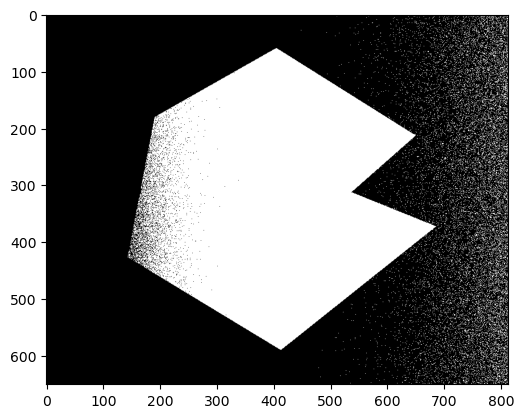

In [50]:
def automatic(name="figura1.png", threshold=1):
    image = cv2.imread(name,cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([image],[0],None,[256],[0,256])

    norm_hist=hist/sum(hist)
    cum_norm_hist = np.cumsum(norm_hist)
    norm_hist=np.squeeze(norm_hist)
    mg = sum([i*norm_hist[i] for i in range(len(hist))]).astype("uint8")
#     print(mg)
    while True:
        m0=(1/cum_norm_hist[mg])*sum([i*norm_hist[i] for i in range(mg)])
        m1=(1/(1-cum_norm_hist[mg]))*sum([i*norm_hist[i] for i in range(mg,len(norm_hist))])
#         print(f"m0 {m0}, m1 {m1}")
        k_new = (m0+m1)/2
#         print(k_new)
        if abs(mg-k_new)<threshold:
            break
        mg=k_new.astype("uint8")

    image = image>k_new
    print(k_new)
    image=image.astype("uint8")
    plt.imshow(image, cmap="gray")
automatic(name="figura4.png")

#### Metoda Otsu

Jednym z częściej wykorzystywanych algorytmów wyznaczania progu jest metoda zaproponowana w roku 1979 przez Nobuyuki Otsu w artykule pt. "A Threshold Selection Method from Gray-Level Histograms" (można odszukać na IEEE Xplore).
W algorytmie zakłada się, że obraz zawiera piksele należące do dwóch klas (obiektów i tła) tj. histogram obrazu jest bi-modalny (ma dwa maksima).
Próg podziału obliczany jest tak, aby wariancja międzyklasowa była maksymalna.
W tym sensie metodę Otsu można nazwać optymalną.

Wprowadźmy teraz wskaźnik "jakości" wybranego progu podziału $k$, który będziemy optymalizować.
W algorytmie Otsu jest to:

\begin{equation}
\label{eq:thresholding:otsu:eta} \tag{11}
\eta(k) = \frac{\sigma^2_B(k)}{\sigma^2_G}
\end{equation}
gdzie:  $\sigma^2_G$ - wariancja globalna, która może zostać obliczona na podstawie momentów statystycznych jako:

\begin{equation}
\label{eq:sigma} \tag{12}
\sigma^2_G =  \sum_{i=0}^{L-1} (i - m_G)^2 p_i
\end{equation}
a $\sigma^2_B$ jest wariancją międzyklasową, która jest zdefiniowana jako:
\begin{equation}
\label{eq:sigma_b} \tag{13}
\sigma^2_B(k) =  P_0(k)(m_0(k) - m_G)^2 + P_1(k)(m_1(k) - m_G)^2
\end{equation}
Równianie to można również przekształcić do:
\begin{equation}
\label{eq:thresholding:otsu:sigma_B_2} \tag{14}
\sigma^2_B(k) =  P_0(k)P_1(k)(m_0(k) - m_1(k))^2 = \frac{(m_G P_0(k) - m(k) )^2}{P_0(k)(1-P_0(k))}
\end{equation}
gdzie:
\begin{equation}
\label{eq:mk} \tag{15}
m(k) = \sum_{i=0}^{k} i p_i
\end{equation}

Taki zapis pozwala przyspieszyć obliczenia.
Wartość $m_G$ wyznaczana jest jednokrotnie, a zachodzi tylko potrzeba obliczania $m(k)$ i $P_0(k)$ w każdej iteracji.
Warto też zwrócić uwagę, że równanie ma sens dla $P_0 > 0$.

Warto zauważyć, że z postaci równania (\ref{eq:thresholding:otsu:sigma_B_2}) wynika, że im większa odległość pomiędzy średnimi $m_0$ i $m_1$ tym wartość wariancji międzyklasowej jest większa.
Pokazuje to, że przyjęty współczynniki może być podstawą do separacji dwóch klas - im jego wartość jest większa, tym lepsze rozdzielenie.
Dodatkowo, z równania (\ref{eq:thresholding:otsu:eta}) wynika, że $\eta(k)$ zależy tylko od wariancji międzyklasowej $\sigma^2_B(k)$, gdyż wariancja globalna $\sigma^2_G$ jest stała.
Zatem w procesie optymalizacji należy dążyć do maksymalizacji wskaźnika $\eta$.

Należy też pamiętać, że współczynnik jest poprawnie określony tylko dla wartości $\sigma^2_G > 0$.
Przy czym, wartość $0$ może on przyjąć tylko dla obrazu o jednym poziomie szarości - w takim przypadku trudno mówić o podziale pikseli na dwie klasy (skoro występuje tylko jedna).

Ostatecznie optymalny próg binaryzacji $\bar{k}$ wyliczamy na podstawie zależności:
\begin{equation}
\label{eq:sigma_B_k} \tag{16}
\sigma^2_B(\bar{k}) \max\limits_{k \in[0,L-1]} {\sigma^2_B(k) }
\end{equation}

Uwagi:
- może się zdarzyć, że znajdziemy więcej niż jedno maksimum tj. więcej wartości $\bar{k}$.
  W takim przypadku zwykle zakłada się, że próg będzie średnią otrzymanych wartości.
- liczby $P_0(\bar{k})$ i $P_1(\bar{k})$ odpowiadają powierzchni zajmowanej przez obiekty klas $C_0$ i $C_1$.
- liczby $m_0(\bar{k})$ i $m_1(\bar{k})$ odpowiadają średniej jasności obiektów klas $C_0$ i $C_1$.
- wartość parametru $\eta(\bar{k})$ określa "jakość" wyznaczonego progu -- im większa tym lepiej.

Zadanie: wykorzystując podane powyżej informacje należy zaimplementować metodę wyznaczania progu binaryzacji zaproponowaną przez Otsu.

1. Wczytaj obraz _coins.png_.
      Wyświetl go.

2. Wyznacz jego histogram znormalizowany oraz oblicz średnią jasność (można do tego wykorzystać histogram) - kod zbliżony do stworzonego wcześniej.

3. Zdefiniuj 256-elementowy wektor na współczynniki $\sigma_B^2$ (funkcja `np.zeros`).

4. W pętli po możliwych wartościach progu binaryzacji wyznacz wartość $\sigma_B^2(k)$ na podstawie zależności (\ref{eq:thresholding:otsu:sigma_B_2}).
      Uwagi:
      - wcześniejszego liczenia wartości $P_0(k)$ i $m(k)$ można uniknąć inkrementując wartośc $P_0, m$  w każdej iteracji.
      - należy pamiętać, że równanie ma sens tylko dla $0 < P_0(k) < 1$. <br>

5. Wyświetl przebieg $\sigma_B^2(k)$.
      Wykorzystaj funkcję `plt.plot`.

6. Wyznacz wartość $\bar{k}$ dla której współczynnik $\sigma_B^2$ jest maksymalny.
	  Można to zrobić poprzez dodanie instrukcji w pętli (rozwiązanie bardziej elegancie) lub wykorzystując funkcję `max` (rozwiązanie dla leniwych).
	  Uwaga. Proszę pominąć obsługę przypadków niejednoznacznego maksimum.

7. Zbinaryzuj obraz wykorzystując otrzymany próg.
      Porównaj wyniki z rezultatem binaryzacji "ręcznej".

8. W OpenCV dostępna jest implementacja metody Otsu - funkcja `cv2.threshold` z parametrem `cv2.THRESH_OTSU`.
      Funkcja zwraca zbinaryzowany obraz oraz próg.
      Wykonaj binaryzację obrazu _coins.png_ metodą Otsu.
      Porównaj wyniki z własną implementacją - powinno wyjść tak samo (tzn. taki sam próg).

9. Przeprowadź eksperyment również na obrazie _rice.png_ i _catalogue.png_

### Binaryzacja lokalna


Analiza wyników binaryzacji dla obrazów _rice.png_ i _catalogue.png_ pokazuje, że globalna binaryzacja nie najlepiej działa dla obrazów o niejednorodnym oświetleniu.
Dla obu obrazów trudno również wyznaczyć odpowiedni próg "ręcznie".

Metodą, która pozwala poprawić wyniki binaryzacji, jest binaryzacja lokalna (niekiedy zwana adaptacyjną).
W jednym z wariantów polega ona na wyznaczeniu progu osobno dla każdego piksela na podstawie jego otoczenia (tj. własności jego kontekstu, okna).

1. Dla uproszczenia zakładamy, że obraz ma rozmiar $256 \times 256$ pikseli. Przyjmijmy okno analizy o rozmiarze 15 pikseli.

2. Najprostsza wersja binaryzacji lokalnej zakłada, że próg binaryzacji dla danego okna to średnia z pikseli w tym oknie.

3. Wczytaj obraz _rice.png_. Rozmiar obrazka (`X,Y`) można uzyskać stosując taką składnię: `(X, Y) = obraz.shape`.

4. Podstawą algorytmu są dwie pętle `for` iterujące po pikselach obrazka:


	for j in range(W/2, Y-W/2):
	    for i in range(W/2, X-W/2):

5. Wewnątrz pętli należy dla każdego piksela wyciąć jego otoczenie o rozmiarze `W` (operator `:`), wyznaczyć z niego średnią (metoda `mean`) i na jej podstawie dokonać binaryzacji.

6. Wyświetl obrazy oryginalny i zbinaryzowany.

7. Zaobserwuj rezultaty działania metody dla obrazów _rice.png_ i _catalogue.png_.
      Poeksperymentuj z rozmiarem okna (proszę nie przesadzać z rozmiarem, gdyż istotnie wpływa on na czas obliczeń).
      Jaka jest podstawowa wada zaimplementowanej metody? (pomijając złożoność obliczeniową).
      Proszę się zastanowić jakie jest źródło błędów.

8. Jakość działania binaryzacji lokalnej można poprawić wyznaczając próg za pomocą metody Sauvol'i i Pietikainen'a zaproponowanej w artykule *Adaptive document image binarization*.
Wykorzystuje ona, oprócz średniej, informację o odchyleniu standardowym w danym oknie.
Próg binaryzacji wyznaczany jest na podstawie zależności:
\begin{equation}
\label{eq:T} \tag{17} 
T = srednia \{1 \pm k (\frac{odchStd}{R}-1) \}
\end{equation}
gdzie: $k$ i $R$ to parametry ($R$ zwykle $128$, a $k$ na początek przyjmij $0.15$), $srednia$ i $odchStd$ to odpowiednio średnia i odchylenie standardowe wyliczone w oknie.

9. Zaimplementuj algorytm Sauvoli - wykorzystaj do wyznaczenia średniej i odchylenia metody `mean()` oraz `std()` liczone dla wycinka (podobnie jak średnia w poprzedniej metodzie).
      
10. Uruchom metodę (uwaga - czas obliczeń nie jest krótki). Przeanalizuj wyniki. Zwróć uwagę, że dodanie informacji o odchyleniu standardowym powinno *poprawić* wyniki binaryzacji.
      Jeżeli dzieje się inaczej, to najprawdopodobniej implementacja zawiera błąd. 
     
11. Zastanów się nad znaczeniem symbolu $\pm$ we wzorze na próg. 
      Kiedy należy zastosować znak +, a kiedy -.

12. Porównaj jakość binaryzacji lokalnej metodą Sauvol'i i z progiem na podstawie średniej. 
      Poeksperymentuj z rozmiarem okna i parametrem k (dla obrazów _rice.png_ i _catalogue.png_).

### Binaryzacja dwuprogowa

Binaryzację można przeprowadzić wykorzystując więciej niż jedn próg.
Przykładem jest binaryzacja dwuprogowa - wybieramy w ten sposób przedział jasności (piksele w nim zawarte klasyfikujemy jako obiekty).

1. Wczytaj obraz _bart.png_. 
Wyświetl go, wyznacz i wyświetl jego histogram.
Oceń, który fragment histogramu odpowiada kolorowi skóry Barta Simpsona.<br>
**UWAGA - Aby odczytać wartości pikseli można zapisać obrazek na dysku (`cv2.imwrite('Nazwa.png', Image)`), a następnie odczytać wartościa programem do edycji obrazów, np. *paint*.**<br>

2. Przeprowadź segmentację na podstawie koloru skóry (binaryzację dwuprogową). 
      Wykorzystaj przekształcenie obrazów z wartościami True, False na wartości 1,0 i mnożenie obrazów.
 
3. Wynik wyświetl.